In [1]:
import pandas as pd

In [2]:
pd.__version__

'1.4.2'

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

Only if next cell doesn't work.

In [5]:
#!pip install pyarrow

Custom function to read and preprocess the data for February.

In [6]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    # Get original number of records
    original_records = df.shape[0]
    
    # Clean for outliers
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    # Get new number of records and percentage of clean data
    no_outliers_records = df.shape[0]
    perc_clean = no_outliers_records/original_records*100
    
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df, perc_clean

## Q1. Downloading the data

We'll use the same NYC taxi dataset, but instead of "Green Taxi Trip Records", we'll use "Yellow Taxi Trip Records".

Download the data for January and February 2023.

**Step 1:** Load the parquet data files.

In [7]:
df_jan = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')


In [8]:
df_jan.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

In [9]:
df_jan.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


Read the data for January. How many columns are there?

**Step 2:** Get number of columns in the parquet file.

In [10]:
len(df_jan.columns)

19

## Q2. Computing duration

Now let's compute the duration variable. It should contain the duration of a ride in minutes.

**Step 1:** Calculate the duration of the trip in minutes for each dataset.

In [11]:
df_jan['duration'] = df_jan.tpep_dropoff_datetime - df_jan.tpep_pickup_datetime
df_jan.duration = df_jan.duration.apply(lambda td: td.total_seconds() / 60)

What's the standard deviation of the trips duration in January?

In [12]:
df_jan.duration.std()

42.594351241920904

## Q3. Dropping outliers

Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

**Step 1:** Remove outliers and keep how many records did you have before cleaning.

In [13]:
original_records_jan = df_jan.shape[0]
df_jan = df_jan[(df_jan.duration >=1) & (df_jan.duration <=60)]
no_outliers_records_jan = df_jan.shape[0]

What fraction of the records left after you dropped the outliers?

**Step 2:** Compute percentage of the records kept after cleaning the outliers.

In [14]:
no_outliers_records_jan/original_records_jan*100

98.1220282212598

## Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

- Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
- Fit a dictionary vectorizer
- Get a feature matrix from it

In [15]:
categorical = ['PULocationID', 'DOLocationID']

In [16]:
df_jan[categorical] = df_jan[categorical].astype(str)
train_dicts = df_jan[categorical].to_dict(orient='records')
dv_jan = DictVectorizer()
X_train_jan = dv_jan.fit_transform(train_dicts)

What's the dimensionality of this matrix (number of columns)?

**Step 1:** See dimensions of the sparse matrix.

In [17]:
X_train_jan

<3009173x515 sparse matrix of type '<class 'numpy.float64'>'
	with 6018346 stored elements in Compressed Sparse Row format>

## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model.
- Train a plain linear regression model with default parameters, where duration is the response variable
- Calculate the RMSE of the model on the training data

**Step 1:** Train the linear regression model with default parameters and with `duration` as the response variable.

In [18]:
target = 'duration'

In [19]:
y_train_jan = df_jan[target].values
lr = LinearRegression()
lr.fit(X_train_jan, y_train_jan)
y_pred = lr.predict(X_train_jan)

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


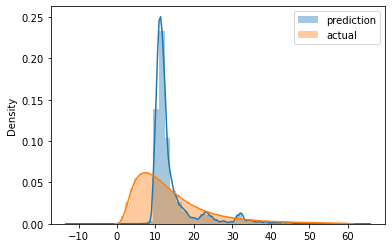

In [20]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train_jan, label='actual')
plt.legend()

What's the RMSE on train?

**Step 2:** Compute the RMSE for train data.

In [21]:
mean_squared_error(y_train_jan, y_pred, squared=False)

7.649261027792376

## Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2023).

**Step 1:** Use the custom function `read_dataframe` to read and preprocess the data from February.

In [22]:
df_feb, perc_clean_feb = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')
df_feb
perc_clean_feb

98.00944077722545

In [23]:
len(df_jan), len(df_feb)

(3009173, 2855951)

**Step 2:** Turn the dataframes into a list of dictionaries, fit a dictionary vectorizer and get a feature matrix from it.

In [24]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_jan[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_feb[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

**Step 3:** Get train and validation response variables.

In [25]:
target = 'duration'
y_train = df_jan[target].values
y_val = df_feb[target].values

**Step 4:** Train the model with the training dataset and validate it with the validation dataset.

In [26]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

What's the RMSE on validation?

**Step 5:** Compute the RMSE for validation data.

In [27]:
mean_squared_error(y_val, y_pred, squared=False)

7.811832836304415